# CA1 Programming project, Cillian Murphy

## <font color='blue'>Data Analysis</font>

Loading Data and libraries


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re 
import unicodedata


# Copy of original data
original_data = pd.read_csv('manager_salary_survey.csv')

# Data for analysation
man_salary_data = pd.read_csv('manager_salary_survey.csv')    

Renaming Columns


In [3]:
man_salary_data.columns = ["timestamp","age","industry","job","add_job_context","salary","compensation","currency","other_currency","income_context","country","us_state","city","years_work_overall","years_work_in_field","education","gender","race"]
man_salary_data.head(1)


,timestamp,age,industry,job,add_job_context,salary,compensation,currency,other_currency,income_context,country,us_state,city,years_work_overall,years_work_in_field,education,gender,race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White


### 1. Examining dataset for form and format of data

Overview of Data

- From this code we can see the data has 27988 rows and 18 columns
- We see that the data types are mostly objects with one exception being the additional_compensation column 
- Lastly we see at the moment the general stats models are not that useful to us as only the additional_compensation is analysable due to the data types at hand

In [4]:
# Prints first few rows

man_salary_data.head()

# Summary of data

man_salary_data.info()

# General Statistical models

man_salary_data.describe()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27989 entries, 0 to 27988
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            27989 non-null  object 
 1   age                  27989 non-null  object 
 2   industry             27917 non-null  object 
 3   job                  27989 non-null  object 
 4   add_job_context      7240 non-null   object 
 5   salary               27989 non-null  object 
 6   compensation         20719 non-null  float64
 7   currency             27989 non-null  object 
 8   other_currency       197 non-null    object 
 9   income_context       3034 non-null   object 
 10  country              27989 non-null  object 
 11  us_state             22993 non-null  object 
 12  city                 27909 non-null  object 
 13  years_work_overall   27989 non-null  object 
 14  years_work_in_field  27989 non-null  object 
 15  education            27773 non-null 

,compensation
count,2.071900e+04
mean,1.819127e+04
std,8.349982e+05
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+03
75%,1.000000e+04
max,1.200000e+08


### 2. Identifying missing/unentered data stats

From this analysis we can see what columns have the highest amount of missing values.

<Axes: >

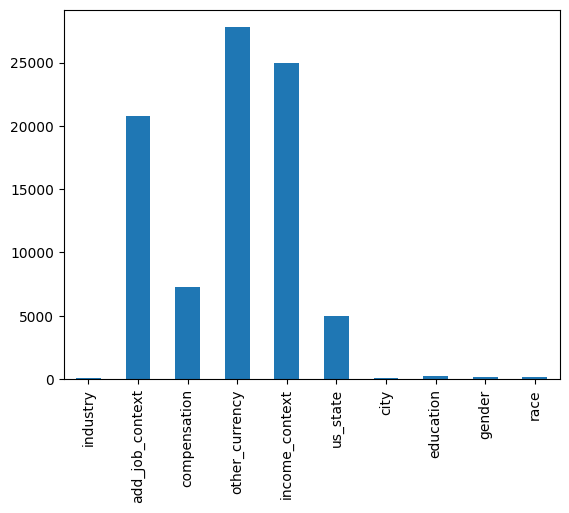

In [5]:
# Getting total sum amount of missing data in each column 
def get_missing_data(data):
    missing_data = data.isnull().sum()
    # Returns columns where there is missing data
    return missing_data[missing_data > 0]

missing_data_greater_0 = get_missing_data(man_salary_data)

# Plotting amount of null values in each column

missing_data_greater_0.plot.bar(x="Column Name", y="Amount of missing values")

### 3. Identifying any outliers for compensation
 Since compensation is the only numerical data at the moment I created a statistical function to get a closer look at the outlier data. It does have a lot of outliers which will skew the final analysis. It also has a big range between the outliers.

In [6]:
def find_outliers(data):
    # First Quantile
    q1 = data.quantile(0.25)
    # Third Quantile
    q3 = data.quantile(0.75)
    # IQR equals third minus the first quantile hence the below equation
    IQR = q3 - q1 
    # Locates the data outside of these two quantiles and returns outliers
    outliers = data[((data<(q1-1.5*IQR)) | (data>(q3+1.5*IQR)))]
    return outliers

outliers = find_outliers(man_salary_data["compensation"])

# Finds number of outliers and converts to string as cannot find length using int object
print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))

outliers

number of outliers: 1980
max outlier value: 120000000.0
min outlier value: 25250.0


40       50000.0
47       40000.0
91       60000.0
152      30000.0
217      30000.0
          ...   
27784    28000.0
27821    60000.0
27860    32000.0
27898    50000.0
27915    30000.0
Name: compensation, Length: 1980, dtype: float64

### 4. Finding unique values in the non-numeric data and understanding what has to be done for each column
 Since the remaining columns are non-numeric I am using the value counts function. This will help me see how many unique values we have in each dataset, meaning I can get a better understanding on what engineering needs to be done to each column so I can then create a common value.

##### Currency Column: 

For this column I will create a currency converter to convert all columns to USD as this is the most common currency.

<Axes: xlabel='currency'>

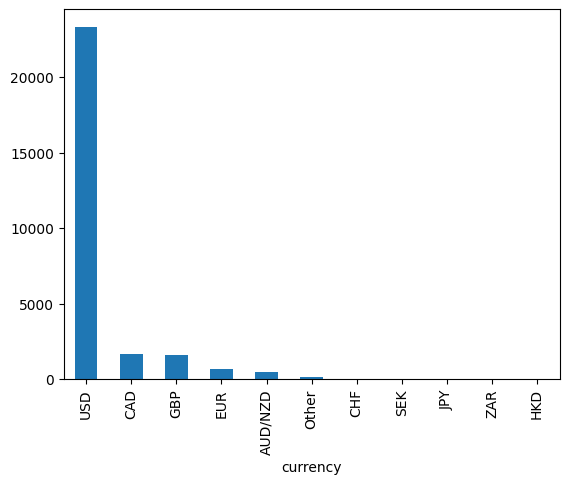

In [7]:
# Count of all currencies
currency_col = man_salary_data.currency.value_counts() # 10 different Currencies including other currencies

# Plotting the different currencies
currency_col.plot.bar(x="Currency", y="Amount")



##### Salary Column:

This column at the moment is a mix of numeric and non-numeric. Will convert this to numeric during data cleaning phase. There is 4290 different salaries. Once I convert all the rows to numeric there will be less as some rows are layed out like 00,000 and other rows are layed out like 00000. I will remove the , so all of the salary data looks the same.

In [8]:
# Amount of different Salaries
salary_col = man_salary_data.salary.value_counts() # 4290 different salaries
salary_col.isnull().sum() # 0 null values



np.int64(0)

##### Country Column:

We have 369 Different Countries

In [9]:
# All Countries column
country_col = man_salary_data.country.value_counts() # 369 different countries

# Finding any null values
country_col_null = man_salary_data.country.isnull().sum() # 0 Null values



We have 249 different non-America countries I found this by just taking the rows that have no US States as only rows in America have this row.
Alltogether we have 4996 rows not accounted for outside of America

In [10]:
# Non-American Countries
null_state_rows_data = man_salary_data[man_salary_data["us_state"].isnull()]

# All countries where the us_state column is null
null_state_rows = null_state_rows_data["country"].value_counts()


To further filter these rows I will use the currency column and relate that to the countries that use that currency. That way I can find common names for each country.

This shows the column for United States Dollars. 

In [11]:
# USD Countries
usd_currency = man_salary_data[man_salary_data["currency"] == "USD"]

# Values count of the countries using the USD currency
usd_countries = usd_currency["country"].value_counts()

This shows all countries that use Canadian dollars I will change all of these rows to just Canada

In [12]:
# CAD Countries
cad_currency = man_salary_data[man_salary_data["currency"] == "CAD"]

# Values count of the countries using the CAD currency
cad_countries = cad_currency["country"].value_counts()

This shows all countries in the GBP column. These will all be changed to UK

In [13]:
# GBP Countries
gbp_currency = man_salary_data[man_salary_data["currency"] == "GBP"]

# Values count of the countries using the GBP currency
gbp_countries = gbp_currency["country"].value_counts()

This shows the countries in the euro currency column. I will create common names for each country

In [14]:
# European Countries column
euro_currency = man_salary_data[man_salary_data["currency"] == "EUR"]

# Values count of the countries using the EUR currency
euro_countries = euro_currency["country"].value_counts()



This shows all the countries that use AUD/NZD. This dataset has AUD and NZD as the same currency so I will use a median currency exchange between each currency to USD and convert the names to Australia or New Zealand.

In [15]:
# AUD/NZD currency countries
aud_nzd_currency = man_salary_data[man_salary_data["currency"] == "AUD/NZD"]

# Values count of the countries using the AUD/NZD currencies
aud_nzd_countries = aud_nzd_currency["country"].value_counts()

This shows all countries in the column of Swedish Krona. These will all be changed to Sweden

In [16]:
# Swedish Krona Countries 
sek_currency = man_salary_data[man_salary_data["currency"] == "SEK"]

# Values count of the countries using the SEK currency
sek_countries = sek_currency["country"].value_counts()

This shows all countries that use the JPY currency. These will be changed to Japan

In [17]:
# JPY countries 
jpy_currency = man_salary_data[man_salary_data["currency"] == "JPY"]

# Values count of the countries using the JPY currency
jpy_countries = jpy_currency["country"].value_counts()

We have 197 other currencies. I found some of the original currencies are also in this column. I will use these rows in the currency converter.

In [18]:
# Other currencies
other = man_salary_data["other_currency"].count() #197 other currencies
other_currencies = man_salary_data["other_currency"].value_counts()

# Checking if any "other currencies" are listed in original currencies
currency_list = ("AUD","NZD","GBP","USD","CAD","EUR","CHF","SEK","JPY","ZAR","HKD","AUD/NZD")
main_other_currencies = man_salary_data['other_currency'][man_salary_data['other_currency'].isin(currency_list)].value_counts()

# Checking for amount of null values
other_currencies_null = man_salary_data.other_currency.isnull().sum() # 27792 null rows

This shows all countries using the ZAR currency. These will all be changed to South Africa

In [19]:
# ZAR countries
zar_currencies = man_salary_data[man_salary_data["currency"] == "ZAR"]

# Values count of the countries using the ZAR currency
zar_countries = zar_currencies["country"].value_counts()

This shows all countries using the HKD currency these will all be changed to Hong Kong.

In [20]:
# Hong Kong Dollars Countries
hkd_currencies = man_salary_data[man_salary_data["currency"] == "HKD"]

# Values count of the countries using the HKD currency
hkd_countries = hkd_currencies["country"].value_counts()


This shows all countries using the CHF currency. These will be changed to Switzerland or Liechenstein. As CHF is only used there.

In [21]:
# CHF Currency
chf_currency = man_salary_data[man_salary_data["currency"] == "CHF"]

# Values count of the countries using the CHF currency
chf_countries = chf_currency["country"].value_counts()

##### State Column:

There is almost 23,000 rows that have a state in that row meaning they have to be in America. I will convert all the country columns to America based off this data

In [22]:
# Count of values in us state column
state_col = man_salary_data.us_state.value_counts()

# All rows that are in america
not_null_state_row = man_salary_data[man_salary_data["us_state"].notnull()]


# Filtering state_col to show only the country
state_null = not_null_state_row["country"]

##### Cities Column:

We have almost 5000 different cities 

In [23]:
# Cities column
city_col = man_salary_data.city.value_counts()


##### Education Column:

This column consists of 6 different education categories. I will convert each degree to a shortened version ie. College Degree to CD for easier analysis.

<Axes: xlabel='education'>

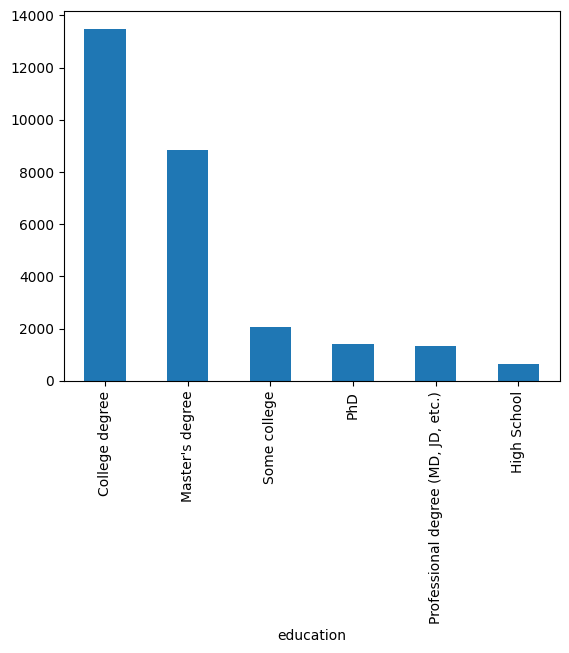

In [24]:
# Education Column
education_col = man_salary_data.education.value_counts()

# Plotting education column
education_col.plot.bar(x="Educcation Level",y ="Amount")

##### Gender Column:

This column consists of 5 different gender categories. I will join the other/prefer not to answer rows.

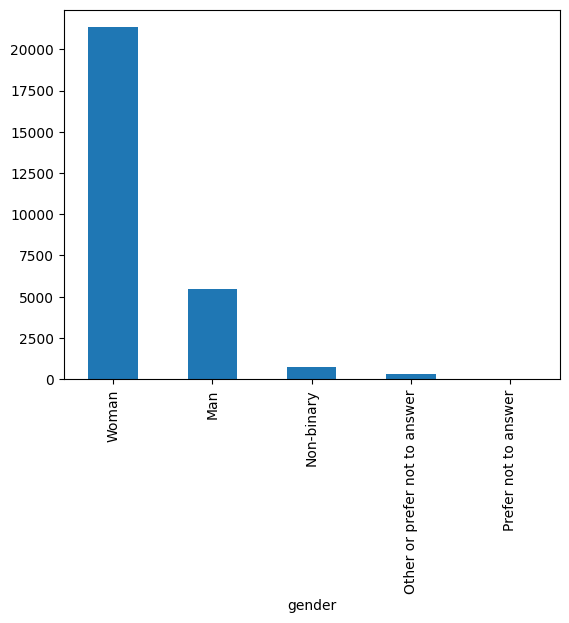

In [25]:
# Gender Column
gender_col = man_salary_data.gender.value_counts()

# Plotting gender column data
gender_col.plot.bar(x= "Gender",y="Amount")

# Null values in the gender column
gender_col_null = man_salary_data.gender.isnull().sum() #167 null rows

##### Race Column:

This column contains many different races for ease of analysis I will create 7 of the most frequent races: White, Asian, Black, Other, Hispanic,  NativeAmerican, MiddleEastern

In [26]:
# Race Column
race_col = man_salary_data.race.value_counts() # 48 different entries

# Any null values in the race column
race_col_null = man_salary_data.race.isnull().sum() # 172 null values

##### Age Column:

The age column has 7 seperate age groups I will number these 1-7 1 being the youngest 7 being the oldest

<Axes: xlabel='age'>

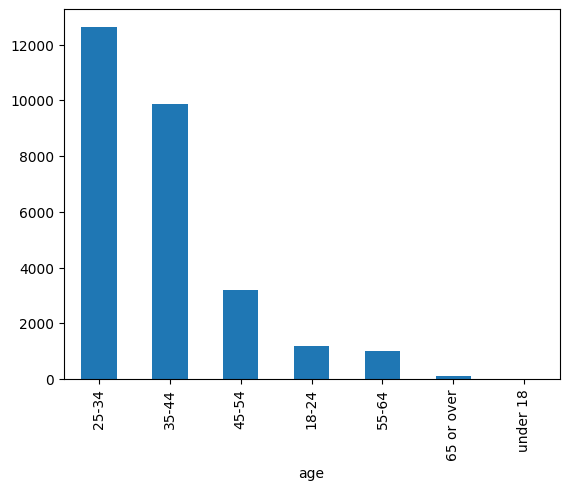

In [27]:
# Age Column
age_col = man_salary_data.age.value_counts()

# Plotting age column
age_col.plot.bar(x="Age",y="Amount")

##### Industry Column:

There is 1216 seperate industries. I will create common names based off most popular industries

In [28]:
# Industry Column
industry_col = man_salary_data.industry.value_counts() # 1216 seperate industries

##### Years worked overall column:

This column has 8 seperate year groups so I will number these from 1-8 with 1 being the lowest and 8 being the highest

In [29]:
# Years worked overall column
years_overall_col = man_salary_data.years_work_overall.value_counts()

##### Years worked in field column:

I will repeat the same process for the years worked overall column here

In [30]:
# Years worked in field column
years_field_col = man_salary_data.years_work_in_field.value_counts()


##### Jobs Column:

There is 14,308 different job values

In [31]:
# Jobs Column
job_col = man_salary_data.job.value_counts()

##### Income Context Column:

We have 2971 different income contexts. This row has 24955 null values. Not much change can be done here.

In [32]:
# Income context column
income_context_col = man_salary_data.income_context.value_counts() # 2971 entries

# Null values within the income context column
income_context_col_null = man_salary_data.income_context.isnull().sum() # 24955 entries

##### Timestamp Column:

There is 27989 entries here. This row is formatted in day/month/year. I will change this to just year

In [33]:
# Timestamp Column
timestamp_col = man_salary_data.timestamp

##### Compensation Column:

We can see that we have 7270 null values and 7929 0 values in the compensation column. I will convert all 0 values to null, use the currency conversion to get the whole column in usd.

In [34]:
# Compensation Column
comp_col = man_salary_data["compensation"]

# Amount of null values
null_comp = comp_col.isnull().sum() # 7270 null values

# Amount of 0 values
comp_zero = (comp_col == 0 ).sum() # 7929

### 5. Finding duplicates
 We have no duplicates in any of the columns. We do not need to any feature engineering for this

In [35]:
duplicates = man_salary_data.duplicated()
man_salary_data[duplicates].sum()

timestamp                0
age                      0
industry                 0
job                      0
add_job_context          0
salary                   0
compensation           0.0
currency                 0
other_currency           0
income_context           0
country                  0
us_state                 0
city                     0
years_work_overall       0
years_work_in_field      0
education                0
gender                   0
race                     0
dtype: object

### Conclusion of analysis of the data manager_salary_survey:

- The dataset has 27,989 rows and 18 columns
- Columns are mostly type object apart from compensation which is type float
- The currency column will all be converted to USD using a currency converter as seen above USD was the most common currency
- For the salary column I will have to convert it all to USD and get rid of any special charachters so all data looks the same
- For the country column I will use the currency column to create common names for all countries outside of America. For America I will use the states column to convert all different spellings of America to USA
- For the other_currency column I will find any currencies from the main currencies column that may have been entered into the other currencies and convert them using the currency converter and also changing the name of those countries accordingly
- For the Education column I will create shorter names for each level of Education for easier analysis
- For the gender column I will change just the other or prefer not to answer option to a common other or prefer not to answer value
- For the Race Column I will create common names for each race based of most frequent races
- For age, years worked overall and years worked in field columns will all be changed from grouped to just numbers 
- For industry column I will create common names for most popular industries
- For timestamp column I will format this so it just shows year rather than day/month/year


# <font color='blue'>Data Cleaning</font>

For the Data Cleaning process I will use a chain of resposibility pipeline to pass the data through and save it to a new csv file with the fully cleaned data ready for analysis!

Why use chain of responsibility?
This allows us to create a "Handler class" which will automatically pass a dataset through a list of different processes rather than rewriting that code for each individual part of the dataset

Handler Class:

In [36]:
class DataCleaner:
    def __init__(self, next: 'DataCleaner' = None):  
        ''' initialise the next handler reference'''
        self.next = next
        
    def process(self, data):
        ''' call process_task on the concrete class
        then calls the next handler'''
        self.process_task(data)
        if self.next is not None:
            self.next.process(data)
    
    def process_task(self, data):
        ''' abstract method'''
        pass
    
    def add_datacleaner(self, datacleaner):
        '''Adds a new handler to the end of the chain '''
        if self.next != None:
            self.next.add_datacleaner(datacleaner)
        else:
            self.next = datacleaner

This code is renaming the countries based off of their currency value in that row. I found USD columns that had no value in the state row so I had to use USD and state to get all of the data to USA.

In [37]:
# Renaming countries based off their currencies
class RenameCountryValuesCurrency(DataCleaner):
    def process_task(self, data):
        # This finds the rows where us_state is not null and turns the country row to USA
        data.loc[data['us_state'].notnull(), 'country'] = 'USA'
        # These take the currency rows where it is = to a particular currency and changes them all to where that currency is used
        data.loc[data["currency"] == "USD", "country"] = "USA"
        data.loc[data["currency"] == "CAD", "country"] = "Canada"
        data.loc[data["currency"] == "GBP", "country"] = "UK"
        data.loc[data["currency"] == "AUD/NZD", "country"] = "Australia/New Zealand"
        data.loc[data["currency"] == "CHF", "country"] = "Switzerland"
        data.loc[data["currency"] == "SEK", "country"] = "Sweden"
        data.loc[data["currency"] == "JPY", "country"] = "Japan"
        data.loc[data["currency"] == "ZAR", "country"] = "South Africa"
        data.loc[data["currency"] == "HKD", "country"] = "Hong Kong"
        data.loc[data["other_currency"] == "CAD", "country"] = "Canada"
        data.loc[data["other_currency"] == "USD","country"] = 'USA'
        data.loc[data["other_currency"] == "GBP", "country"] = "UK"
        data.loc[data["other_currency"] == "AUD", "country"] = "Australia"
        data.loc[data["other_currency"] == "NZD", "country"] = "New Zealand"
        data.loc[data["other_currency"] == "CHF", "country"] = "Switzerland"
        data.loc[data["other_currency"] == "SEK", "country"] = "Sweden"
        data.loc[data["other_currency"] == "JPY", "country"] = "Japan"
        data.loc[data["other_currency"] == "ZAR", "country"] = "South Africa"
        data.loc[data["other_currency"] == "HKD", "country"] = "Hong Kong"
          

        

Since Euro is used in many different countries across Europe this means I can not apply a similar process with the currency. So I just found all of the different names for each country and created a common name for that country

In [38]:
        
class RenameCountryEuro(DataCleaner):
        def process_task(self, data):
            # This lowers all the names of the countries to lower case
            data['country'] = data['country'].str.strip()
            # This normalizes all words so there are no hidden letters 
            data['country'] = data['country'].apply(lambda x: unicodedata.normalize('NFKD', x))
            Germany_data = {"Germany","germany", "Company in Germany. I work from Pakistan."}
            # These loop through the different names of the country and changes the spelling so they are all the same
            for ger in Germany_data:
                data.loc[data["country"] == ger, "country"] = "Germany"
            ireland_data = {"Ireland","Ireland","ireland"}
            for ire in ireland_data:
                data.loc[data["country"] == ire, "country"] = "Ireland"
            France_data = {"France", "FRANCE","France","france"}
            for fra in France_data:
                data.loc[data["country"] == fra, "country"] = "France"
            Netherlands_data = {"Netherlands","The Netherlands","Netherlands","netherlands","The Netherlands","The netherlands","the Netherlands","Nederland","NL","the netherlands"}
            for net in Netherlands_data:
                data.loc[data["country"] == net, "country"] = "Netherlands"
            Spain_data = {"Spain","Spain","spain"}
            for sp in Spain_data:
                data.loc[data["country"] == sp, "country"] = "Spain"
            Belgium_data = {"Belgium","Belgium"}
            for bel in Belgium_data:
                data.loc[data["country"] == bel, "country"] = "Belgium"
            Austria_data = {"Austria","Austria, but I work remotely for a Dutch/British company"}
            for aus in Austria_data:
                data.loc[data["country"] == aus, "country"] = "Austria"
            Finland_data = {"Finland","finland"}
            for fin in Finland_data:
                data.loc[data["country"] == fin, "country"] = "Finland"
            Italy_data = {"Italy","Italy (South)"}
            for ita in Italy_data:
                data.loc[data["country"] == ita, "country"] = "Italy"
            Denmark_data = {"Denmark","denmark"}
            for den in Denmark_data:
                data.loc[data["country"] == den, "country"] = "Denmark"
            Luxembourg_data = {"Luxembourg", "Luxemburg"}
            for lux in Luxembourg_data:
                data.loc[data["country"] == lux, "country"] = "Luxembourg"
            UK_data = {"UK","Uk","U.K."}
            for uk in UK_data:
                data.loc[data["country"] == uk, "country"] = "UK"
            usa_data = {"United States of America","USA"}
            for us in usa_data:
                data.loc[data["country"] == us, "country"] = "USA"

This code is renaming a couple different rows as the way I renamed them was quite similar so I grouped them together. We have the Age column where I just made a new value for each age group and same with the years worked. For the gender column I just created a common value for other/prefer not to answer. For Education I created abreviated names for easier understanding

In [39]:
class RenameYearsAgeGenderEducation(DataCleaner):
    def process_task(self, data):
        # Same as above
        def rename_age(data):
            age_data = {"under 18":1,"18-24":2,"25-34":3,"35-44":4,"45-54":5,"55-64":6,"65 or over":7}
            for age in age_data:
                data.loc[data["age"] == age, "age"] = age_data[age]
        rename_age(data)

        def years_col(data):
            years_data = {"1 year or less": 1,"2 - 4 years": 2, "5-7 years": 3, "8 - 10 years": 4, "11 - 20 years": 5, "21 - 30 years": 6, "31 - 40 years": 7, "41 years or more": 8}
            for years in years_data:
                data.loc[data["years_work_in_field"] == years, "years_work_in_field"] = years_data[years]
                data.loc[data["years_work_overall"] == years, "years_work_overall"] = years_data[years]
        years_col(data)
            
        def rename_gender(data):
            data.loc[data["gender"] == "Prefer not to answer", "gender"] = "Other or prefer not to answer"
        rename_gender(data)

        def rename_edu(data):
            data['education'] = data['education'].str.strip()
            data['education'] = data['education'].str.lower()
            data["education"] = data["education"].str.replace(",", "")
            data["education"] = data["education"].str.replace(".", "")
            data["education"] = data["education"].str.replace("'", "")
            data["education"] = data["education"].str.replace(")", "")
            data["education"] = data["education"].str.replace("(", "")
            data["education"] = data["education"].str.replace(" ", "_")
        
            edu_data = {"college_degree":"CD","masters_degree":"MD","some_college":"SC","professional_degree_md_jd_etc":"ProDeg","high_school":"HS"}
            for edu in edu_data:
                data.loc[data["education"].str.contains(edu,na = False), "education"] = edu_data[edu]
        rename_edu(data)



This is my Currency Converter. The first part is just normalizing the punctuation of the salary column. I then created a dictionary for each of the main currencies and found the rows where the values equaled that currency and multiplied them by their respective currency exchange rate. I then changed all of their names to USD. I applied a similar process for compensation column and the other currencies column.

In [40]:
class CurrencyConverter(DataCleaner):
    def process_task(self, data):
        # Convert salary to numeric function
                def convert_salary(data):
                        data["salary"] = data["salary"].str.replace(",", "")
                        data["salary"] = data["salary"].astype(int)

                # Conversion rate for og currencies
                def convert_to_usd(data):
                        # Exchange Rate Dictionary
                        exchange_rates = {"CAD":1.4, "GBP": 0.79, "EUR":0.94,"AUD/NZD": 1.62,"CHF": 0.88,"SEK": 10.91,"JPY":154.6, "ZAR": 17.94, "AUD": 1.54,"NZD": 1.7}
                        # Looping through that dictionary and creating 2 different variables in the for loop to assign to each variable in the dictionary using .items()
                        for exchange, rate in exchange_rates.items():
                                # selecting the rows that contain the respective currencies and multiplying their exchange rates by their rows salary column
                                data.loc[data["currency"] == exchange, "salary"] = (data.loc[data["currency"] == exchange, "salary"] * rate)

                # Convert og currencies to USD
                def convert_currency_usd(data):
                        currencies = ("CAD", "GBP", "EUR", "AUD/NZD", "CHF", "SEK", "JPY", "ZAR","HKD")
                        data.loc[data["currency"].isin(currencies), "currency"] = "USD"

                # Convert other currency to usd
                def convert_to_usd_other(data):
                        exchange_rates = {"CAD":1.4, "GBP": 0.79, "EUR":0.94,"AUD/NZD": 1.62,"CHF": 0.88,"SEK": 10.91,"JPY":154.6, "ZAR": 17.94, "AUD": 1.54,"NZD": 1.7}
                        for exchange, rate in exchange_rates.items():
                                data.loc[data["other_currency"] == exchange, "salary"] = (data.loc[data["other_currency"] == exchange, "salary"] * rate)

                # Convert other currencies to USD
                def convert_other_currency_usd(data):
                        oth_currencies = ("CAD", "GBP", "EUR", "AUD/NZD", "CHF", "SEK", "JPY", "ZAR","HKD","AUD","NZD")
                        data.loc[data["other_currency"].isin(oth_currencies), "other_currency"] = "USD"


                def comp_to_usd(data):
                        exchange_rates = {"CAD":1.4, "GBP": 0.79, "EUR":0.94,"AUD/NZD": 1.62,"CHF": 0.88,"SEK": 10.91,"JPY":154.6, "ZAR": 17.94, "AUD": 1.54,"NZD": 1.7}
                        for exchange, rate in exchange_rates.items():
                                data.loc[data["currency"] == exchange, "compensation"] = (data.loc[data["currency"] == exchange, "compensation"] * rate)

                convert_salary(data)
                convert_to_usd(data)
                comp_to_usd(data)
                convert_currency_usd(data)
                convert_to_usd_other(data)
                convert_other_currency_usd(data)

This creates a new csv file and writes all of the cleaned data into it.

In [41]:
class WriteToNewCSV(DataCleaner):
    def process_task(self, data):
        # writing cleaned data to new csv
        return data.to_csv("manager_cleaned.csv")

This replaces all of the null and 0 values with zeros then replaces them all as null values. I also dropped additional job context and income context as I didnt feel they were necessary for analysis.

In [42]:
class FillNA(DataCleaner):
    def process_task(self, data):
        def fill_na_drop(data):
            # Filling any null values in compensation with 0
            data["compensation"].fillna(0,inplace=True)
            # Changing all 0 values to null
            data["compensation"].replace(0, np.nan, inplace=True)

            # Dropping job context and income context
            data.drop(columns=["add_job_context","income_context"],inplace = True)
        fill_na_drop(data)


This changes the timestamp to a datetime value, takes just the year part of the value and puts it to a new column called year. I also had to set the index to year so I could update the value inside of timestamp.

In [43]:
class ChangeTimestamp(DataCleaner):
    def process_task(self, data):
        # Turning timestamp to datetime type
        data["timestamp"] = pd.to_datetime(data["timestamp"])
        # Finding just the year of the row and creating a new column containing just the year
        data['year'] = data['timestamp'].dt.strftime('%Y')
        data.set_index("year")


I grouped all these renaming functions together as they were similar functions. I went through a lot of the cities column and created common names for those cities and normalized their punctuation too. I then applied a similar process to states, industries and race.

In [44]:
class RenameCols(DataCleaner):
    def process_task(self, data):
        def renamecities(data):
            # Normalising all cities to same punctuation
            data['city'] = data['city'].str.strip()
            data['city'] = data['city'].str.lower()
            data["city"] = data["city"].str.replace(",", "")
            data["city"] = data["city"].str.replace(".", "")
            data["city"] = data["city"].str.replace(" ", "_")

            city_data = {"chicago":"chicago","boston":"boston","new_york":"nyc","seattle":"seattle","london":"london","san_francisco":"san francisco","los_angeles":"los angeles","new_york_city":"nyc","portland":"portland","washington_dc":"washington","toronto":"toronto","minneapolis":"minneapolis","atlanta":"atlanta","philadelphia":"philadelphia","denver":"denver","houston":"houston","pittsburgh":"pittsburgh","vancouver":"vancouver","dallas":"dallas","cambridge":"cambridge","columbus":"columbus","madison":"madison","san_diego":"san diego","indianapolis":"indianapolis","baltimore":"baltimore","raleigh":"raleigh","remote":"remote","cleveland":"cleveland","st_louis":"st louis","richmond":"richmond","ottawa":"ottawa","phoenix":"phoenix","dc":"washington","arlington":"arlington","nashville":"nashville","durham":"durham","melbourne":"milwaukee","cincinnati":"cincinnati","charlotte":"charlotte","san_jose":"san jose","sacramento":"sacramento","detroit":"detroit","salt_lake_city":"salt lake city","rochester":"rochester","oakland":"oakland","kansas_city":"kansas city","manchester":"manchester","sydney":"sydney","orlando":"orlando","louisville":"louisville","dublin":"dublin","ann_arbor":"ann harbor","alexandria":"alexandria","st_paul":"st paul","montreal":"montreal","calgary":"calgary","birmingham":"birmingham","tampa":"tampa","edmonton":"edmonton","des_moines":"des moines","columbia":"columbia","boulder":"boulder","tucson":"tucson","san_antonio":"san antonio","omaha":"omaha","edinburgh":"edinburgh","new_orleans":"new orleans","irvine":"irvine","albany":"albany","grand_rapids":"grand rapids","albuquerque":"albuquerque","brooklyn":"brooklyn","lexington":"lexington","springfield":"springfield","glasgow":"glasgow","buffalo":"buffalo","hartford":"hartford","berlin":"berlin","las_vegas":"las vegas","jacksonville":"jacksonville","rockville":"rockville","oklahoma_city":"oklahoma_city","leeds":"leeds","saint_paul":"saint paul","bristol":"bristol","winnipeg":"winnipeg","brisbane":"brisbane","boise":"boise","memphis":"memphis","wellington":"wellington","auckland":"auckland","coloardo_springs":"colorado springs","redmond":"redmond","bloomington":"bloomington","burlington":"burlington","halifax":"halifax","fort_worth":"fort worth","betheseda":"betheseda","amsterdam":"amsterdam","providence":"providence","wilmington":"wilmington","bay_area":"bay area","bellevue":"bellevue","oxford":"oxford","tacoma":"tacoma","fairfax":"fairfax","harrisburg":"harrisburg","paris":"paris","fort_collins":"fort collins","wichita":"wichita","syracuse":"syracuse","tulsa":"tulsa","newark":"newark","anchorage":"anchorage","charleston":"charleston","victoria":"victoria","perth":"perth","miami":"miami","eugene":"eugene","salem":"salem","lansing":"lansing","lincoln":"lincoln","dayton":"dayton","knoxville":"knoxville","huntsville":"huntsville","chapel_hill":"chapel hill","silver_spring":"silver spring","princeton":"princeton","palo_alto":"palo alto","prefer_not_to_answer":"na","reston":"reston","spokane":"spokane","new_haven":"new haven","saint_louis":"st louis","greenville":"greenville","athens":"athens","munich":"munich","santa_clara":"santa clara","berkeley":"berekely","mclean":"mclean","mountain_view":"mountain view","greensboro":"greensboro","sunnyvale":"sunnyvale","missoula":"missoula","gainesville":"gainesville","canberra":"canberra","adelaide":"adelaide","chattanooga":"chattanooga","vienna":"vienna","olympia":"olympia","toldeo":"toledo","worcester":"worcester","long_beach":"long beach","troy":"troy","brighton":"brighton","norfolk":"norfolk","waltham":"waltham","tallahassee":"tallahassee","manhattan":"manhattan","nottingham":"nottingham"}
            # Loops through above data finds where it contains that word and changes it to its common name
            for city in city_data:
                data.loc[data["city"].str.contains(city,na = False), "city"] = city_data[city]
        renamecities(data)

        def rename_states2(data):
            data['us_state'] = data['us_state'].str.strip()
            data['us_state'] = data['us_state'].str.lower()
            states_data = {"new york":"ny","california":"california","massachusetts":"massachusetts","texas":"texas","illinois":"illinois","washington":"washington","columbia":"columbia","pennsylvania":"pennsylvania","virginia":"virgina","minnesota":"minnesota","ohio":"ohio","colorado":"colorado","oregon":"oregon","north carolina":"nc","maryland":"maryland","michigan":"michigan","georgia":"georgia","florida":"florida","wisconsin":"wisconsin","new jersey":"nj","iowa":"iowa","mississippi":"mississippi","utah":"utah","alabama":"alabama","kansas":"kansas","montana":"montana"}
            for states in states_data:
                data.loc[data["us_state"].str.contains(states,na = False), "us_state"] = states_data[states]
        rename_states2(data)

        def rename_industries(data):
            data['industry'] = data['industry'].str.strip()
            data['industry'] = data['industry'].str.lower()
            ind_data = {"education":"education","tech":"tech","health":"health","government":"government","govt":"government","pharma":"pharmaceutical","research":"research","oil":"oil","librar":"library","museum":"museum","construction":"construction","accounting":"accounting,banking & finance","engineering":"engineering or manufacturing","manufacturing":"engineering or manufacturing","biotech":"biotech","bitech":"biotech","communications":"communications","marketing":"marketing,advertising & pr","consulting":"business or consulting","retail":"retail","sales":"sales","sale":"sales","agriculture":"agriculture or forestry","fitness":"leisure,sport & tourism","restaurant":"hospitality & events","food service":"hospitality & events","software":"tech","automotive":"automotive","vetenary medicine":"pharmaceutical","scientific research":"science","biology":"science","life science":"science","estate":"real estate","environmental":"environmental","edicine":"pharmaceutical","veterinary":"pharmaceutical","defenc":"defence","soldier":"defence","design":"art & design","architecture":"architecture","contracting":"contracting","energy":"energy","book publishing":"publishing"}
            for ind in ind_data:
                data.loc[data["industry"].str.contains(ind,na = False), "industry"] = ind_data[ind]
        rename_industries(data)

        def rename_race(data):
            race_data = {"Asian or Asian American":"Asian","White":"White","Black or African American":"Black","Another option not listed here or prefer not to answer":"Other","Hispanic":"Hispanic","Native American or Alaska Native":"Native American","Middle Eastern or Northern African":"Middle Eastern"}
            for race in race_data:
                data.loc[data["race"].str.contains(race,na = False), "race"] = race_data[race]
        rename_race(data)


This is my full chain of responsibility, I put all the renaming classes first as they didnt affect my other functions. I then put currency converter second to last as that did change the values that I used to change the names of the countries and states

In [45]:
chain = RenameCols(RenameYearsAgeGenderEducation(RenameCountryEuro(RenameCountryValuesCurrency(FillNA(ChangeTimestamp(CurrencyConverter(WriteToNewCSV())))))))
chain.process(man_salary_data)

C:\Users\Cillian\AppData\Local\Temp\ipykernel_15488\2778080148.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["compensation"].fillna(0,inplace=True)
C:\Users\Cillian\AppData\Local\Temp\ipykernel_15488\2778080148.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

PermissionError: [Errno 13] Permission denied: 'manager_cleaned.csv'

In [46]:
man_salary_data.head()

,timestamp,age,industry,job,salary,compensation,currency,other_currency,country,us_state,city,years_work_overall,years_work_in_field,education,gender,race,year
0,2021-04-27 11:02:10,3,education,Research and Instruction Librarian,55000.0,NaN,USD,NaN,USA,massachusetts,boston,3,3,MD,Woman,White,2021
1,2021-04-27 11:02:22,3,tech,Change & Internal Communications Manager,43134.0,3160.0,USD,NaN,UK,NaN,cambridge,4,3,CD,Non-binary,White,2021
2,2021-04-27 11:02:38,3,"accounting,banking & finance",Marketing Specialist,34000.0,NaN,USD,NaN,USA,tennessee,chattanooga,2,2,CD,Woman,White,2021
3,2021-04-27 11:02:41,3,nonprofits,Program Manager,62000.0,3000.0,USD,NaN,USA,wisconsin,milwaukee,4,3,CD,Woman,White,2021
4,2021-04-27 11:02:42,3,"accounting,banking & finance",Accounting Manager,60000.0,7000.0,USD,NaN,USA,south carolina,greenville,4,3,CD,Woman,White,2021


In [47]:
original_data.head()

,Timestamp,How old are you?,What industry do you work in?,Job title,"If your job title needs additional context, please clarify here:","What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)","How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.",Please indicate the currency,"If ""Other,"" please indicate the currency here:","If your income needs additional context, please provide it here:",What country do you work in?,"If you're in the U.S., what state do you work in?",What city do you work in?,How many years of professional work experience do you have overall?,How many years of professional work experience do you have in your field?,What is your highest level of education completed?,What is your gender?,What is your race? (Choose all that apply.)
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White
